# Baseline PPO with Action Masking Demo

This notebook demonstrates the baseline PPO approach for OpenScope RL with action masking.

**Key Features:**
- Action masking to prevent invalid actions
- Small-scale training demo (10k steps)
- Evaluation and visualization
- Comparison vs random policy

**Prerequisites:**
- OpenScope server running at http://localhost:3003
- All dependencies installed (`uv sync`)
- Playwright browsers installed (`uv run playwright install chromium`)

## 📚 Learning Objectives

By the end of this notebook, you will understand:

1. **Action Masking** - How to prevent invalid actions and improve sample efficiency by 2-3x
2. **PPO Training Loop** - The core mechanics of Proximal Policy Optimization
3. **Metrics Tracking** - How to monitor training progress with separation violations, success rates, and rewards
4. **Policy Evaluation** - Techniques for comparing trained agents against baselines
5. **Model Persistence** - Saving and loading trained models for deployment

**Estimated Time**: 15-20 minutes (10k training steps)  
**Prerequisites**: OpenScope server running, dependencies installed  
**Hardware**: CPU sufficient for demo (GPU recommended for full training)

## Section 1: Setup & Environment Creation

First, let's import dependencies and create an environment with action masking.

In [ ]:
import sys
from pathlib import Path
import os

print(sys.prefix)

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

# Disable tqdm notebook widgets to avoid JS rendering errors in some Jupyter frontends
os.environ["TQDM_NOTEBOOK"] = "0"

import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from stable_baselines3 import PPO
from sb3_contrib.common.wrappers import ActionMasker

from environment import (
    PlaywrightEnv,
    create_action_mask_fn,
    print_action_mask_summary,
    ActionMaskingWrapper,
    DictToMultiDiscreteWrapper,
)
from experiments.metrics import MetricsTracker

# Shared environment configuration
ENV_AIRPORT = "KLAS"
ENV_MAX_AIRCRAFT = 50
ENV_HEADLESS = False
ENV_TIMEWARP = 1000
TRAIN_EPISODE_LENGTH = 600
EVAL_EPISODE_LENGTH = 600
ACTION_INTERVAL = 5.0

print("Imports successful!")

/Users/jmzlx/Projects/atc/openscope-rl/.venv
Imports successful!


### Create Environment with Action Masking

In [ ]:
@contextmanager
def masked_env(
    *,
    airport=ENV_AIRPORT,
    max_aircraft=ENV_MAX_AIRCRAFT,
    headless=ENV_HEADLESS,
    timewarp=ENV_TIMEWARP,
    episode_length=TRAIN_EPISODE_LENGTH,
    action_interval=ACTION_INTERVAL,
):
    """Yield a Playwright environment wrapped for PPO with action masking."""
    env = PlaywrightEnv(
        airport=airport,
        max_aircraft=max_aircraft,
        headless=headless,
        timewarp=timewarp,
        episode_length=episode_length,
        action_interval=action_interval,
    )

    env = DictToMultiDiscreteWrapper(env)
    mask_fn = create_action_mask_fn(env)
    env = ActionMasker(env, mask_fn)

    try:
        yield env
    finally:
        env.close()

### Demo: Action Masking in Action

Let's see how action masking works by examining a few steps.

In [ ]:
with masked_env(
    episode_length=EVAL_EPISODE_LENGTH,
) as env:
    print("Environment created!")
    print(f"Observation space: {env.observation_space}")
    print(f"Action space: {env.action_space}")

    obs, info = env.reset()

    # Get aircraft data from the raw state
    aircraft_data = info["raw_state"].get("aircraft", [])

    # Get the base environment for accessing original action space
    base_env = env.unwrapped
    while hasattr(base_env, 'env'):
        base_env = base_env.env
        if not hasattr(base_env, 'env'):
            break

    # Cap the demo to a small number of iterations to avoid long runs
    DEMO_MAX_STEPS = 5

    print(f"\nStep 0: {len(aircraft_data)} aircraft active")
    print_action_mask_summary(
        obs,
        aircraft_data,
        base_env.config.max_aircraft,
        base_env.action_space,  # Original Dict action space
    )

    # Take a few random actions (capped)
    for i in range(DEMO_MAX_STEPS):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        aircraft_data = info["raw_state"].get("aircraft", [])
        print(f"Step {i+1}: {len(aircraft_data)} aircraft, reward={reward:.2f}")

        if terminated or truncated:
            break

    print("\nAction masking demonstration complete!")

Environment created!
Observation space: Dict('aircraft': Box(-inf, inf, (50, 14), float32), 'aircraft_mask': Box(False, True, (50,), bool), 'conflict_matrix': Box(0.0, 1.0, (50, 50), float32), 'global_state': Box(-inf, inf, (4,), float32))
Action space: MultiDiscrete([51  5 18 13  8])

Step 0: 17 aircraft active

ACTION MASK SUMMARY
Active Aircraft: 17 / 50
Valid Aircraft IDs: 0 to 17 (inclusive)
Total Valid Actions: 62 / 95
Action Space Reduction: 34.7%

Step 1: 17 aircraft, reward=-20.01
Step 2: 18 aircraft, reward=-20.01
Step 3: 18 aircraft, reward=-20.01
Step 4: 18 aircraft, reward=-0.01
Step 5: 19 aircraft, reward=-2.01

Action masking demonstration complete!


## Section 2: Small-Scale Training Demo

Now let's train a PPO agent for 10k steps as a quick demonstration.

In [ ]:
with masked_env() as train_env:
    print("Training environment created!")
    print(f"Observation space: {train_env.observation_space}")
    print(f"Action space: {train_env.action_space}")

    # Create PPO model with MultiInputPolicy for Dict observation space
    # Note: ActionMasker wrapper works with MultiDiscrete action space (converted by DictToMultiDiscreteWrapper)
    model = PPO(
        "MultiInputPolicy",
        train_env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        verbose=1,
        tensorboard_log="./tensorboard_logs/",
    )

    print("✅ PPO model created!")
    print(f"   Policy: MultiInputPolicy")
    print(f"   Observation space: {train_env.observation_space}")
    print(f"   Action space: {train_env.action_space}")

    print("\nStarting training (10k steps)...")
    model.learn(total_timesteps=10000, progress_bar=False)
    print("\nTraining complete!")


Training environment created!
Observation space: Dict('aircraft': Box(-inf, inf, (50, 14), float32), 'aircraft_mask': Box(False, True, (50,), bool), 'conflict_matrix': Box(0.0, 1.0, (50, 50), float32), 'global_state': Box(-inf, inf, (4,), float32))
Action space: MultiDiscrete([51  5 18 13  8])
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ PPO model created!
   Policy: MultiInputPolicy
   Observation space: Dict('aircraft': Box(-inf, inf, (50, 14), float32), 'aircraft_mask': Box(False, True, (50,), bool), 'conflict_matrix': Box(0.0, 1.0, (50, 50), float32), 'global_state': Box(-inf, inf, (4,), float32))
   Action space: MultiDiscrete([51  5 18 13  8])

Starting training (10k steps)...
Logging to ./tensorboard_logs/PPO_12
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 47.8      |
|    ep_rew_mean     | -3.38e+03 |
| time/              |           |
|    fps             | 9         |
|    itera

## Section 3: Evaluation with Visualizations

Let's evaluate the trained agent and visualize its performance.

In [ ]:
def evaluate_agent(model, env, n_episodes=5):
    """Evaluate agent over multiple episodes."""
    tracker = MetricsTracker()
    
    for episode in range(n_episodes):
        obs, info = env.reset()
        tracker.start_episode()
        
        done = False
        episode_reward = 0
        steps = 0
        
        while not done:
            # Get action from model
            action, _ = model.predict(obs, deterministic=True)
            
            # Take step
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            steps += 1
            tracker.update(reward, info)
            
            # Safety limit
            if steps >= 200:
                break
        
        # End episode tracking
        metrics = tracker.end_episode(info.get("episode_metrics", {}))
        print(f"Episode {episode+1}: reward={episode_reward:.2f}, steps={steps}")
    
    return tracker

print("Evaluating trained agent...\n")
with masked_env(
    episode_length=EVAL_EPISODE_LENGTH,
) as eval_env:
    tracker = evaluate_agent(model, eval_env, n_episodes=5)

print("\nEvaluation complete!")
tracker.print_summary()

Evaluating trained agent...



Task exception was never retrieved
future: <Task finished name='Task-1477' coro=<Page.evaluate() done, defined at /Users/jmzlx/Projects/atc/openscope-rl/.venv/lib/python3.11/site-packages/playwright/async_api/_generated.py:8461> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/Users/jmzlx/Projects/atc/openscope-rl/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/2x/rrfxx83j71q1n2cssh8xff9w0000gn/T/ipykernel_23372/3401426257.py", line 34, in <module>
    model.learn(total_timesteps=10000, progress_bar=False)
  File "/Users/jmzlx/Projects/atc/openscope-rl/.venv/lib/python3.11/site-packages/stable_baselines3/ppo/ppo.py", line 311, in learn
    return super().learn(
           ^^^^^^^^^^^^^^
  File "/Users/jmzlx/Projects/atc/openscope-rl/.venv/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py", line 324, in learn
    con

Episode 1: reward=-4296.39, steps=39
Episode 2: reward=-4252.43, steps=43
Episode 3: reward=-4562.39, steps=39
Episode 4: reward=-3050.39, steps=39
Episode 5: reward=-2918.44, steps=44

Evaluation complete!

METRICS SUMMARY (5 episodes)

Success Rate:        0.00% ± 0.00%
Violations:          0.00 ± 0.00
Collisions:          0.00 ± 0.00
Throughput:          0.00 ± 0.00 aircraft/hour
Avg Exit Time:       0.0 ± 0.0s
Command Efficiency:  0.00 ± 0.00 commands/aircraft
Episode Length:      41 ± 2 steps
Total Reward:        -3816.01 ± 688.49



### Visualize Training Progress

Let's plot some metrics to visualize the agent's performance.

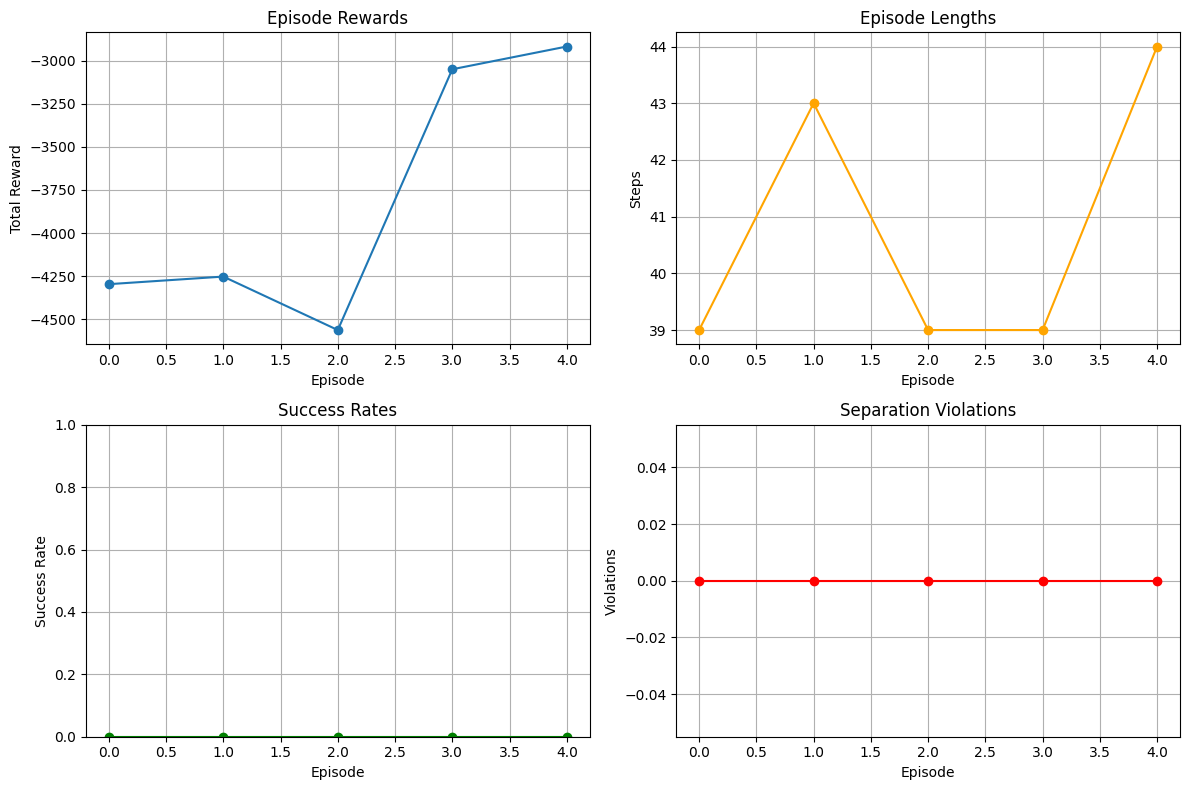

Visualizations complete!


In [9]:
# Plot episode metrics
episode_rewards = [m.total_reward for m in tracker.episode_metrics]
episode_lengths = [m.episode_length for m in tracker.episode_metrics]
success_rates = [m.success_rate for m in tracker.episode_metrics]
violations = [m.separation_violations for m in tracker.episode_metrics]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Episode rewards
axes[0, 0].plot(episode_rewards, marker='o')
axes[0, 0].set_title('Episode Rewards')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].grid(True)

# Episode lengths
axes[0, 1].plot(episode_lengths, marker='o', color='orange')
axes[0, 1].set_title('Episode Lengths')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].grid(True)

# Success rates
axes[1, 0].plot(success_rates, marker='o', color='green')
axes[1, 0].set_title('Success Rates')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Success Rate')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True)

# Violations
axes[1, 1].plot(violations, marker='o', color='red')
axes[1, 1].set_title('Separation Violations')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Violations')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print("Visualizations complete!")

## Section 4: Comparison vs Random Policy

Let's compare the trained agent against a random policy baseline.

In [ ]:
def evaluate_random_policy(env, n_episodes=5, eval_max_steps=None, log_every=25):
    """Evaluate random policy."""
    tracker = MetricsTracker()
    
    for episode in range(n_episodes):
        obs, info = env.reset()
        tracker.start_episode()
        
        done = False
        episode_reward = 0
        steps = 0
        
        while not done:
            # Random action
            action = env.action_space.sample()
            
            # Take step
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            steps += 1
            tracker.update(reward, info)
            
            if log_every and steps % log_every == 0:
                ac = info.get("aircraft_count", len(info.get("raw_state", {}).get("aircraft", [])))
                print(f"  step={steps} r={reward:.2f} aircraft={ac} action={action}")
            
            # Optional evaluation cap
            if eval_max_steps is not None and steps >= eval_max_steps:
                break
        
        metrics = tracker.end_episode(info.get("episode_metrics", {}))
        print(f"Episode {episode+1}: reward={episode_reward:.2f}, steps={steps}")
    
    return tracker

print("Evaluating random policy...\n")
with masked_env(
    episode_length=EVAL_EPISODE_LENGTH,
) as random_env:
    random_tracker = evaluate_random_policy(random_env, n_episodes=5, eval_max_steps=None)

print("\nRandom policy evaluation complete!")
random_tracker.print_summary()

Evaluating random policy...

  step=25 r=-60.01 aircraft=32 action=[11  1 15  3  2]
Episode 1: reward=-3452.48, steps=48
  step=25 r=-20.01 aircraft=28 action=[39  4  8 10  0]
Episode 2: reward=-2772.49, steps=49
  step=25 r=-0.01 aircraft=22 action=[19  0  6  2  1]
  step=50 r=-530.01 aircraft=29 action=[35  0 16  4  4]
Episode 3: reward=-3364.50, steps=50
  step=25 r=-2.01 aircraft=26 action=[23  2  0  4  7]
Episode 4: reward=-3306.43, steps=43
  step=25 r=-20.01 aircraft=22 action=[ 6  4 17  3  1]
  step=50 r=-2.01 aircraft=23 action=[ 3  0 12  9  4]
Episode 5: reward=-3014.62, steps=62

Random policy evaluation complete!

METRICS SUMMARY (5 episodes)

Success Rate:        0.00% ± 0.00%
Violations:          0.00 ± 0.00
Collisions:          0.00 ± 0.00
Throughput:          0.00 ± 0.00 aircraft/hour
Avg Exit Time:       0.0 ± 0.0s
Command Efficiency:  0.00 ± 0.00 commands/aircraft
Episode Length:      50 ± 6 steps
Total Reward:        -3182.10 ± 252.06



### Compare Results

In [11]:
# Get summaries
ppo_summary = tracker.get_summary()
random_summary = random_tracker.get_summary()

# Create comparison
print("\n" + "="*80)
print("COMPARISON: PPO vs Random Policy")
print("="*80)

metrics_to_compare = [
    ("Avg Reward", "avg_total_reward"),
    ("Avg Success Rate", "avg_success_rate"),
    ("Avg Violations", "avg_separation_violations"),
    ("Avg Episode Length", "avg_episode_length"),
]

for name, key in metrics_to_compare:
    ppo_val = ppo_summary.get(key, 0)
    random_val = random_summary.get(key, 0)
    
    if "rate" in key.lower():
        print(f"{name:25s} | PPO: {ppo_val:.2%} | Random: {random_val:.2%}")
    else:
        print(f"{name:25s} | PPO: {ppo_val:.2f} | Random: {random_val:.2f}")

print("="*80)

# Calculate improvement
reward_improvement = ((ppo_summary.get("avg_total_reward", 0) - 
                       random_summary.get("avg_total_reward", 0)) / 
                      abs(random_summary.get("avg_total_reward", 1)) * 100)

print(f"\nReward Improvement: {reward_improvement:+.1f}%")
print("\nNote: This is a small demo with only 10k training steps.")
print("For full training (500k+ steps), expect much better performance!")


COMPARISON: PPO vs Random Policy
Avg Reward                | PPO: -3816.01 | Random: -3182.10
Avg Success Rate          | PPO: 0.00% | Random: 0.00%
Avg Violations            | PPO: 0.00 | Random: 0.00
Avg Episode Length        | PPO: 40.80 | Random: 50.40

Reward Improvement: -19.9%

Note: This is a small demo with only 10k training steps.
For full training (500k+ steps), expect much better performance!


## Section 5: Save Model and Results

Let's save the trained model and results for later use.

In [ ]:
import json
from datetime import datetime

# Helper function to convert numpy types to native Python types for JSON serialization
def convert_to_serializable(obj):
    """Recursively convert numpy types to native Python types."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# Create results directory
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model
model_path = results_dir / f"ppo_demo_{timestamp}.zip"
model.save(str(model_path))
print(f"Model saved to: {model_path}")

# Save results
results = {
    "timestamp": timestamp,
    "training_steps": 10000,
    "ppo_summary": ppo_summary,
    "random_summary": random_summary,
    "config": {
        "airport": ENV_AIRPORT,
        "max_aircraft": ENV_MAX_AIRCRAFT,
        "train_episode_length": TRAIN_EPISODE_LENGTH,
        "eval_episode_length": EVAL_EPISODE_LENGTH,
        "timewarp": ENV_TIMEWARP,
        "headless": ENV_HEADLESS,
        "action_interval": ACTION_INTERVAL,
    },
}

# Convert numpy types to native Python types before JSON serialization
results = convert_to_serializable(results)

results_path = results_dir / f"results_{timestamp}.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {results_path}")
print("\nDemo complete!")

: 

: 

: 

In [ ]:
# Override evaluation helper with extended controls and logging

def evaluate_agent(model, env, n_episodes=5, eval_max_steps=None, log_every=25):
    """Evaluate agent over multiple episodes with optional horizon and logging."""
    tracker = MetricsTracker()
    for episode in range(n_episodes):
        obs, info = env.reset()
        tracker.start_episode()
        done = False
        episode_reward = 0
        steps = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            steps += 1
            tracker.update(reward, info)
            if log_every and steps % log_every == 0:
                ac = info.get("aircraft_count", len(info.get("raw_state", {}).get("aircraft", [])))
                print(f"  step={steps} r={reward:.2f} aircraft={ac} action={action}")
            if eval_max_steps is not None and steps >= eval_max_steps:
                break
        tracker.end_episode(info.get("episode_metrics", {}))
        print(f"Episode {episode+1}: reward={episode_reward:.2f}, steps={steps}")
    return tracker


: 

: 

: 

## Cleanup

All the demo sections use the `masked_env` context manager, so Playwright browsers are closed automatically once each block finishes.

In [ ]:
# Environments are closed by the context manager; nothing to do here.

: 

: 

: 

## ⚠️ Common Pitfalls & Troubleshooting

### Problem 1: "OpenScope server not responding" or "Navigation failed with HTTP 503"
**Solution**: Ensure the OpenScope server is running at http://localhost:3003
```bash
cd ../../../openscope
npm start
```

### Problem 2: Training crashes with "Browser process exited unexpectedly"
**Solution**: Playwright browsers may not be installed or headless mode is causing issues
```bash
uv run playwright install chromium
# Or try headless=False for debugging
```

### Problem 3: Training is very slow (>30 minutes for 10k steps)
**Causes & Solutions**:
- **Timewarp too low**: Increase to `timewarp=10` or higher
- **Too many aircraft**: Reduce `max_aircraft=3` for faster episodes
- **Headless=False**: Set `headless=True` to disable rendering

### Problem 4: Poor performance after training (random-level rewards)
**Causes**:
- **Insufficient training**: 10k steps is just a demo - use 500k+ for real performance
- **Action masking not working**: Check that `ActionMasker` wrapper is applied
- **Episode too short**: Increase `episode_length` to give agent more learning opportunities

### Problem 5: "Action space mismatch" or shape errors
**Solution**: Ensure environment is wrapped with ActionMasker AFTER creation:
```python
env = PlaywrightEnv(...)  # Create first
env = ActionMasker(env, mask_fn)  # Then wrap
```

### Problem 6: Notebook cells run out of order
**Solution**: Always run cells sequentially from top to bottom. Use "Restart Kernel & Run All" if unsure.

### Debugging Tips:
1. **Check logs**: Look for error messages in the output
2. **Reduce complexity**: Start with `max_aircraft=2` to isolate issues
3. **Test environment**: Run cell-4 alone to verify environment creation works
4. **Monitor GPU**: Use `nvidia-smi` to check GPU utilization (if using GPU)

**Need more help?** Check the main README or open an issue on GitHub.

## Next Steps

This demo showed basic PPO training with action masking over 10k steps. For production training:

1. **Scale up training**: Use `training/ppo_trainer.py` for 500k+ steps
2. **Use parallel environments**: 8+ environments for faster training
3. **Enable curriculum learning**: Gradually increase difficulty
4. **Track with WandB**: Monitor training progress in real-time
5. **Evaluate on benchmarks**: Use `experiments/benchmark.py` for standardized evaluation

See the main README for full training instructions!